# BUILDING AN AUTOMATED IMAGE COLORIZATION MODEL - GAN-UNET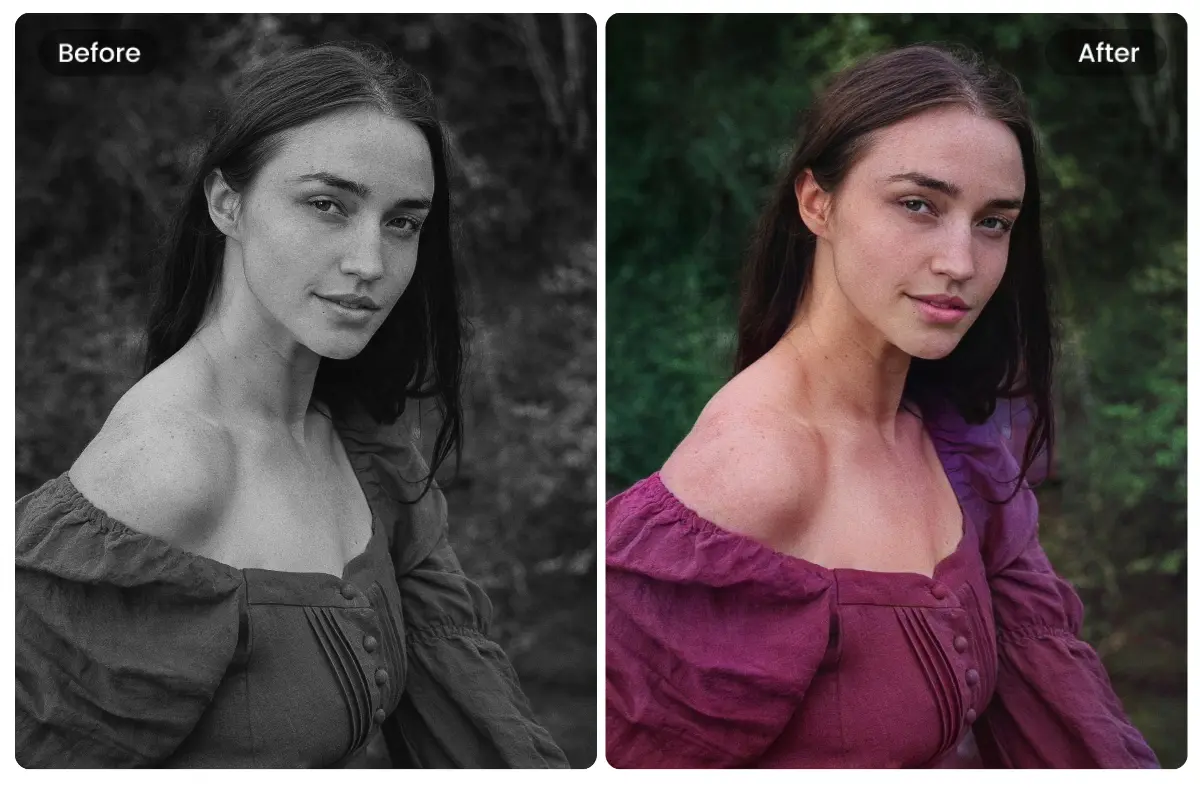

**Import Library**

In [ ]:
import glob
import numpy as np
from PIL import Image

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

#**I. Load data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the directory containing the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/Dataset' #path to your dataset
use_colab = True

##**2. Load image from Dataset on Google Drive**

In [ ]:
import os
from tqdm.notebook import tqdm
from pathlib import Path

if use_colab == True:
    path = dataset_path
else:
    path = "Your path to the dataset"
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    images = images[0:2000]
    # return  np.random.choice(images, 1000)
    return  np.array(images)
images=images_upload(path)
print(images.shape)
print(images)

  0%|          | 0/5490 [00:00<?, ?it/s]

(2000,)
['/content/drive/MyDrive/Dataset/1 (1152).jpg'
 '/content/drive/MyDrive/Dataset/1 (1110).jpg'
 '/content/drive/MyDrive/Dataset/1 (1157).jpg' ...
 '/content/drive/MyDrive/Dataset/1 (365).jpg'
 '/content/drive/MyDrive/Dataset/1 (3636).jpg'
 '/content/drive/MyDrive/Dataset/1 (3482).jpg']


#**3. Convert data into input and label sets**

In [ ]:
SIZE = 128

In [ ]:
import cv2
from skimage.color import rgb2lab, lab2rgb

def convert_image_labels(images):
    labels=[]
    for i in tqdm(images):
        i = cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        res_i=cv2.resize(i,(SIZE,SIZE))
        del i
        labels.append(res_i)
    return labels


def convert_image_inputs(images):
    inputs=[]
    for z in tqdm(images):
        z = cv2.imread(z)
        z=cv2.cvtColor(z,  cv2.COLOR_BGR2GRAY)
        res_z=cv2.resize(z,(SIZE,SIZE))
        del z
        inputs.append(res_z)
    return inputs

labels=convert_image_labels(images)
inputs=convert_image_inputs(images)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
print(labels)
print(inputs)

Streaming output truncated to the last 5000 lines.
       [  2,   1,  15, ...,  32,  43,  39],
       [  1,   6,  58, ...,  30,  31,  35]], dtype=uint8), array([[162, 167, 162, ..., 156, 156, 155],
       [164, 166, 161, ..., 156, 159, 154],
       [165, 163, 162, ..., 157, 153, 156],
       ...,
       [139, 139, 138, ..., 193, 193, 190],
       [131, 135, 133, ..., 188, 186, 183],
       [134, 134, 135, ..., 183, 189, 184]], dtype=uint8), array([[222, 209, 145, ..., 132, 130, 128],
       [219, 187, 177, ..., 133, 131, 128],
       [216, 145, 162, ..., 133, 134, 130],
       ...,
       [229, 226, 184, ..., 188, 189, 164],
       [231, 223, 182, ..., 192, 176, 141],
       [234, 227, 181, ..., 190, 150, 132]], dtype=uint8), array([[215, 216, 217, ..., 221, 222, 222],
       [218, 219, 219, ..., 223, 223, 225],
       [218, 219, 221, ..., 223, 223, 225],
       ...,
       [  9,   7,   9, ...,  14,  12,  15],
       [  7,   8,   8, ...,  14,  14,  14],
       [  8,   8,   8, ...,  13,

In [ ]:
def convert_image_inputs(images):
    labels = []
    for image_path in images:
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            res_img = cv2.resize(img, (SIZE, SIZE))
            labels.append(res_img)
    return labels
labels=convert_image_labels(images)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

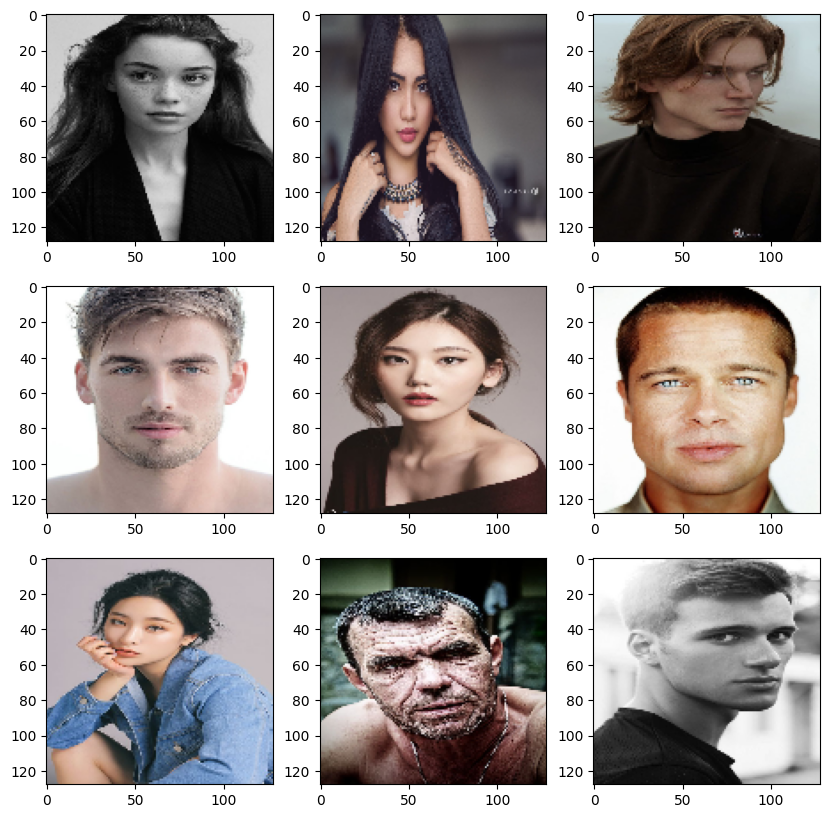

In [ ]:
def show_labels(labels):
    plt.figure(figsize=(10,10))
    for i in range(9):
        idx=np.random.randint(0,len(labels))
        plt.subplot(3,3,i+1)
        img=labels[idx]
        plt.imshow(img)

show_labels(labels)

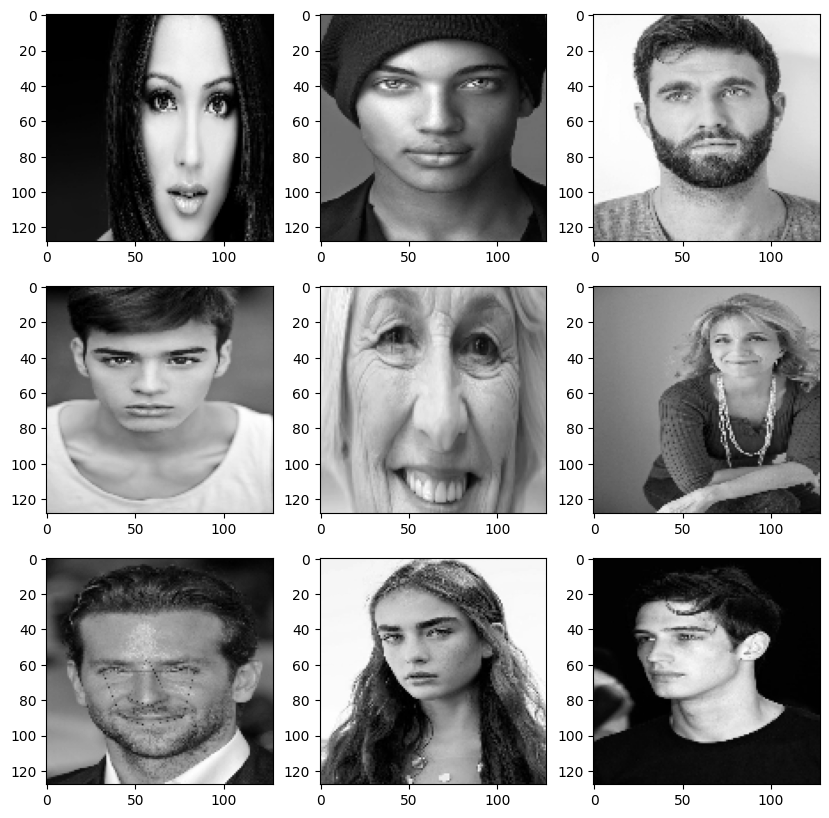

In [ ]:
def show_input(inputs):
    plt.figure(figsize=(10,10))
    for i in range(9):
        idx=np.random.randint(0,len(inputs))
        plt.subplot(3,3,i+1)
        img=inputs[idx]
        plt.imshow(img,cmap='gray')
show_input(inputs)

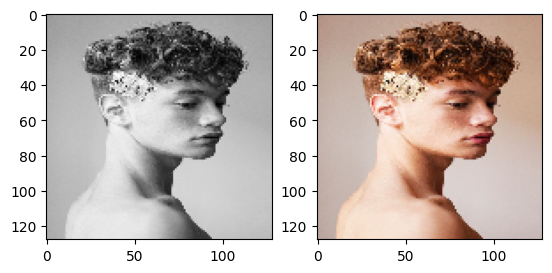

In [ ]:
def images_compare(inputs,labels):
    idx_new=np.random.randint(0,len(labels))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(inputs[idx_new],cmap='gray')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(labels[idx_new])
    plt.show()
images_compare(inputs,labels)

#**4. Split data to Train/Test set**


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(inputs,labels,test_size=0.2):
    labels=np.array(labels)
    inputs=np.array(inputs)
    x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=test_size)
    return x_train, x_test ,y_train,y_test

In [ ]:
x_train,x_test ,y_train, y_test=split_data(inputs,labels,test_size=0.2)
x_train, x_test=x_train/255.0,x_test/255.0
y_train, y_test=y_train/255.0,y_test/255.0

#**Build model GAN-Unet**

##**1. Build GENERATOR(Unet)**

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, UpSampling2D, Concatenate, ELU, Input, LeakyReLU, MaxPooling2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.layers import Concatenate

In [ ]:
#GEN 128x128

In [ ]:
def build_generator(inputsize=(128, 128, 1)):
    input = Input(shape=inputsize)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv1')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x1 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv3')(x)
    x = BatchNormalization()(x1)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv4')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x2 = Conv2D(128, (3, 3), padding="same", strides=(1, 1), kernel_initializer='he_normal', name='Conv6')(x)
    x = BatchNormalization()(x2)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv7')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv8')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x3 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv9')(x)
    x = BatchNormalization()(x3)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv10')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv11')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x4 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv12')(x)
    x = BatchNormalization()(x4)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool4')(x)

    x = Conv2D(1024, (3, 3), padding="same", name='Conv13')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1024, (3, 3), padding="same", name='Conv14')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1024, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv15')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate([x, x4])()
    x = Concatenate(axis=3)([x, y])

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv16')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv17')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv18')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate([x, x3], axis=3)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv19')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv20')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv21')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate([x, x2], axis=3)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv22')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv23')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv24')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate([x, x1], axis=3)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv25')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv26')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv27')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    outputs = Conv2D(3, (1, 1), padding="same", activation='tanh', name='Generator_Output')(x)

    generator_model = tf.keras.Model(inputs=input, outputs=outputs)
    generator_model.summary()
    return generator_model

In [ ]:
def build_generator(inputsize=(128, 128, 1)):
    input = Input(shape=inputsize)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv1')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x1 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv3')(x)
    x = BatchNormalization()(x1)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv4')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x2 = Conv2D(128, (3, 3), padding="same", strides=(1, 1), kernel_initializer='he_normal', name='Conv6')(x)
    x = BatchNormalization()(x2)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv7')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv8')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x3 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv9')(x)
    x = BatchNormalization()(x3)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv10')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv11')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x4 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv12')(x)
    x = BatchNormalization()(x4)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool4')(x)

    x = Conv2D(1024, (3, 3), padding="same", name='Conv13')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1024, (3, 3), padding="same", name='Conv14')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1024, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv15')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate(axis=3)([x, x4])

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv16')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv17')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv18')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate(axis=3)([x, x3])

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv19')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv20')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv21')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate(axis=3)([x, x2])

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv22')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv23')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv24')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Concatenate(axis=3)([x, x1])

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv25')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv26')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv27')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    outputs = Conv2D(3, (1, 1), padding="same", activation='tanh', name='Generator_Output')(x)

    generator_model = tf.keras.Model(inputs=input, outputs=outputs)
    generator_model.summary()
    return generator_model

In [ ]:
generator = build_generator(inputsize=(SIZE, SIZE, 1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 64)         640       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_52 (Ba  (None, 128, 128, 64)         256       ['Conv1[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_52 (LeakyReLU)  (None, 128, 128, 64)         0         ['batch_normalization_52[0

**Note:** In this case, we previously trained the GAN-Unet model with SIZE=64x64. However, the output may not be of high quality with this size. Therefore, if you want better results, adjust SIZE=128 instead of SIZE=64 and train the model accordingly. Then, save the model as 'generator_model.h5'. Finally, use the two code cells below to transfer the trained weights from the SIZE=64 model to the SIZE=128 model in order to save resources. After successfully completing this process, proceed to run the cells below to obtain the complete GAN-Unet model with SIZE=128.

##**2. Build DISCRIMINATOR(CNN)**

In [ ]:
def build_discriminator():

    activation = tf.keras.layers.LeakyReLU(alpha=0.2)

    inputs = Input(shape=(SIZE, SIZE, 3))


    conv1 = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = activation(conv1)
    conv1 = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = activation(conv1)
    conv1 = MaxPooling2D()(conv1)

    conv2 = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = activation(conv2)
    conv2 = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = activation(conv2)
    conv2 = MaxPooling2D()(conv2)

    conv3 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = activation(conv3)
    conv3 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = activation(conv3)
    conv3 = MaxPooling2D()(conv3)

    conv4 = Conv2D(512, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = activation(conv4)
    conv4 = Conv2D(512, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = activation(conv4)
    conv4 = MaxPooling2D()(conv4)

    conv5 = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = activation(conv5)
    conv5 = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = activation(conv5)

    fully = Flatten()(conv5)
    fully = Dense(512)(fully)
    fully = BatchNormalization()(fully)
    fully = activation(fully)
    fully = Dense(128)(fully)
    fully = BatchNormalization()(fully)
    fully = activation(fully)
    fully = Dense(32)(fully)
    fully = BatchNormalization()(fully)
    fully = activation(fully)
    fully = Dense(1, activation='sigmoid')(fully)

    model = tf.keras.models.Model(inputs, fully)
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
discriminator = build_discriminator()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_83 (Ba  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_83 (LeakyReLU)  multiple                     0         ['batch_normalization_83

##**3. Build a complete GAN model from the two Generator and Discriminator models above**

In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    input = tf.keras.Input(shape=(SIZE, SIZE, 1))
    generated_image = generator(input)
    validity = discriminator(generated_image)
    gan = tf.keras.Model(inputs=input, outputs=[generated_image, validity])
    gan.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.9999, 0.0001], optimizer='adam')
    gan.summary()
    return gan

gan = build_gan(generator, discriminator)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       50258499  
                                                                 
 model_1 (Functional)        (None, 1)                 52486529  
                                                                 
Total params: 102745028 (391.94 MB)
Trainable params: 50238915 (191.65 MB)
Non-trainable params: 52506113 (200.29 MB)
_________________________________________________________________


#**Train model**

In [ ]:
import time

def train_gan(generator, discriminator, gan, x_train, y_train, epochs=1000, batch_size=64):
    batch_count = x_train.shape[0] // batch_size
    d_loss_list = []
    g_loss_list = []

    for e in range(epochs):
        start_time = time.time()  # Time start

        for _ in range(batch_count):
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_images = y_train[idx]
            gray_images = x_train[idx]

            fake_images = generator.predict(gray_images)

            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, valid)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            valid = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(gray_images, [real_images, valid])

        end_time = time.time()  # Time end
        elapsed_time = end_time - start_time

        print(f"Epoch {e}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss[0]}, Time: {elapsed_time:.2f} seconds")

        # Save loss
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss[0])

        # Compute remaining time
        remaining_time = (epochs - e - 1) * elapsed_time
        hours = int(remaining_time // 3600)
        minutes = int((remaining_time % 3600) // 60)
        print(f"Estimated time remaining: {hours} hours {minutes} minutes")

    return d_loss_list, g_loss_list


In [ ]:
num_epochs = 200
d_loss_list, g_loss_list = train_gan(generator, discriminator, gan, x_train, y_train, epochs=num_epochs, batch_size=32)

1/1 [==============================] - 26s 26s/step
Epoch 0/200, D Loss: 0.6443975567817688, G Loss: 0.01931806467473507, Time: 10876.27 seconds
Estimated time remaining: 601 hours 12 minutes
1/1 [==============================] - 24s 24s/step


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(d_loss, g_loss, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), d_loss, label="Discriminator Loss")
    plt.plot(range(num_epochs), g_loss, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(d_loss_list, g_loss_list, num_epochs)


#**Show results**

In [ ]:
def generate_colored_images(generator, gray_images):
    colored_images = generator.predict(gray_images)
    return colored_images

In [ ]:
num_examples_to_generate = len(x_test)
generated_images = generate_colored_images(generator, x_test)

def result_compare(y_test, pred, x_test):
    num_samples = len(y_test)

    for idx in range(num_samples):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(x_test[idx], cmap='gray')
        ax1.set_title('Input')
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(pred[idx])
        ax2.set_title('Output')
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(y_test[idx])
        ax3.set_title('Original image')
        plt.show()

result_compare(y_test, generated_images, x_test)



#**Save model to deploy to website**

In [ ]:
from tensorflow.keras.models import load_model

generator.save('generator_model_128.h5')

In [ ]:
from google.colab import files
file_path = '/content/generator_model_128.h5'
files.download(file_path)